In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from pyts.datasets import make_cylinder_bell_funnel
import ruptures as rpt
import shap
import matplotlib.cm as cm
import matplotlib

In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [3]:
random_state = 0

# IMPORT DATASET

In [4]:
dataset_name = "cbf"

In [5]:
X_all, y_all = make_cylinder_bell_funnel(n_samples = 600, random_state = random_state)
X_all = X_all.reshape((X_all.shape[0], X_all.shape[1], 1))

In [6]:
print("X SHAPE: ", X_all.shape)
print("y SHAPE: ", y_all.shape)
unique, counts = np.unique(y_all, return_counts=True)
print("\nCLASSES BALANCE")
for i, label in enumerate(unique):
    print(label, ": ", round(counts[i]/sum(counts), 2))

X SHAPE:  (600, 128, 1)
y SHAPE:  (600,)

CLASSES BALANCE
0 :  0.33
1 :  0.33
2 :  0.33


## DATASET SPLIT

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
# BLACKBOX/EXPLANATION SETS SPLIT
X_train, X_exp, y_train, y_exp = train_test_split(X_all, y_all, 
                                                  test_size=0.3, stratify = y_all, random_state=random_state)

# BLACKBOX TRAIN/TEST SETS SPLIT
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, 
                                                  test_size=0.2, stratify = y_train, random_state=random_state)

# BLACKBOX TRAIN/VALIDATION SETS SPLIT
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, stratify = y_train, random_state=random_state)

# EXPLANATION TRAIN/TEST SETS SPLIT
X_exp_train, X_exp_test, y_exp_train, y_exp_test = train_test_split(X_exp, y_exp, 
                                                                    test_size=0.2, 
                                                                    stratify = y_exp, 
                                                                    random_state=random_state)

# EXPLANATION TRAIN/VALIDATION SETS SPLIT
X_exp_train, X_exp_val, y_exp_train, y_exp_val = train_test_split(X_exp_train, y_exp_train, 
                                                                  test_size=0.2, 
                                                                  stratify = y_exp_train, 
                                                                  random_state=random_state)

print("SHAPES:")
print("BLACKBOX TRAINING SET: ", X_train.shape)
print("BLACKBOX VALIDATION SET: ", X_val.shape)
print("BLACKBOX TEST SET: ", X_test.shape)
print("EXPLANATION TRAINING SET: ", X_exp_train.shape)
print("EXPLANATION VALIDATION SET: ", X_exp_val.shape)
print("EXPLANATION TEST SET: ", X_exp_test.shape)

SHAPES:
BLACKBOX TRAINING SET:  (268, 128, 1)
BLACKBOX VALIDATION SET:  (68, 128, 1)
BLACKBOX TEST SET:  (84, 128, 1)
EXPLANATION TRAINING SET:  (115, 128, 1)
EXPLANATION VALIDATION SET:  (29, 128, 1)
EXPLANATION TEST SET:  (36, 128, 1)


In [9]:
n_timesteps, n_outputs, n_features = X_train.shape[1], len(np.unique(y_all)), 1 
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)

TIMESTEPS:  128
N. LABELS:  3


# BLACKBOX MODEL

In [10]:
from joblib import load
import keras
"""import importlib
importlib.reload(blackboxes)"""
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import time
import blackboxes
from blackboxes import *

Using TensorFlow backend.
/Users/francesco/anaconda3/envs/tesi/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/francesco/anaconda3/envs/tesi/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/francesco/anaconda3/envs/tesi/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/frances

## resnet

In [11]:
blackbox = build_resnet(n_timesteps, n_outputs)
blackbox.load_weights(parentdir + "/blackbox_checkpoints/cbf_blackbox_resnet_20191106_145242_best_weights_+1.00_.hdf5")
resnet = blackbox

Instructions for updating:
Colocations handled automatically by placer.


### KNN

In [59]:
knn = load(parentdir + "/blackbox_checkpoints/cbf_blackbox_knn_20191106_145654.joblib")

# AUTOENCODER

In [12]:
"""import importlib
importlib.reload(autoencoders)"""
import autoencoders
from autoencoders import *

## Standard

In [13]:
params = {"input_shape": (n_timesteps,1),
          "n_blocks": 8, 
          "latent_dim": 2,
          "encoder_latent_layer_type": "dense",
          "encoder_args": {"filters":[2,4,8,16,32,64,128,256], 
                            "kernel_size":[21,18,15,13,11,8,5,3], 
                            "padding":"same", 
                            "activation":"elu", 
                            "pooling":[1,1,1,1,1,1,1,1]}
         }

aut = Autoencoder(verbose = False, **params)
encoder, decoder, autoencoder = aut.build()
autoencoder.load_weights(parentdir + "/autoencoder_checkpoints/cbf_autoencoder_20191106_144056_best_weights_+1.0504_.hdf5")
ae = autoencoder

In [73]:
from myutils import BlackboxPredictWrapper
blackbox = knn
blackbox_predict = BlackboxPredictWrapper(blackbox, 2)
blackbox_input_dimensions = 2
labels = ["cylinder", "bell", "funnel"]
figsize = (20,3)

### SHAP BY SEGMENT

In [15]:
def segment_ts(ts, model = "rbf", jump = 5, pen = 1, figsize = (20,3), plot = True):
    # detection
    algo = rpt.Pelt(model=model, jump = jump).fit(ts)
    result = algo.predict(pen=pen)

    # display
    if plot:
        rpt.display(ts, true_chg_pts = result, computed_chg_pts=result, figsize = figsize)
        plt.show()
    return result

def generate_segment_list(segmentation):
    # from list of ending segment idxs to list of tuple with starting and ending idxs
    # ex. [5,9,12] --> [(0,5),(5,9),(9,12)]
    segment_list = []
    if len(segmentation) == 1:
        segment_list.append((0,segmentation[0]))
    for i in range(len(segmentation) - 1):
        if i == 0:
            segment_list.append((0, segmentation[i]))
        segment_list.append((segmentation[i], segmentation[i + 1]))
    return segment_list

def gen_val(segment, ts):
    # linear interpolation between two points
    n_points = np.abs(np.diff(segment))[0]
    if segment[1] == len(ts):
        change_amplitude = ts[segment[0]] - ts[segment[1]-1]
    else:
        change_amplitude = ts[segment[0]] - ts[segment[1]]
    steps = abs(change_amplitude/n_points)
    new_vals = []
    for i in range(0,n_points):
        if change_amplitude > 0:
            new_vals.append(ts[segment[0]] - ((i*steps)))
        else:
            new_vals.append(ts[segment[0]] + ((i*steps)))
    return np.array(new_vals)

def linear_consecutive_segmentation(z, segmentation):
    # different type of segmentation: if there are consecutive ones in z the count as only one one
    # ex. z = [0,1,1,0,1,1,1,0] --> z = [0,1,0,1,0]
    new_segmentation = []
    i = 0
    while i < len(segmentation):
        idx = segmentation[i]
        if z[i] == 1:
            if (i + 1 == len(segmentation)) or (z[i + 1] == 0):
                new_segmentation.append(idx)
            else:
                i += 1
                continue
        else:
            new_segmentation.append(idx)
        i += 1
    new_z = z[np.insert(np.diff(z).astype(np.bool), 0, True)]
    return new_z, new_segmentation


def mask_ts(zs, segmentation, ts, background):

    zs = 1 - zs # invert 0 and 1 for np.argwhere
    ts = ts.ravel().copy()

    segment_list = generate_segment_list(segmentation)

    masked_tss = []
    for z in zs:
        if background == "linear_consecutive":
            z, new_segmentation = linear_consecutive_segmentation(z, segmentation)
            segment_list = generate_segment_list(new_segmentation)
        seg_to_change = np.argwhere(z).ravel()
        masked_ts = ts.copy()
        for seg_index in seg_to_change:
            if background in ["linear", "linear_consecutive"]:
                masked_ts[segment_list[seg_index][0]:segment_list[seg_index][1]] = gen_val(segment_list[seg_index], ts)
            else:
                masked_ts[segment_list[seg_index][0]:segment_list[seg_index][1]] = background
        masked_tss.append(masked_ts)
    masked_tss = np.array(masked_tss)
    return masked_tss


def plot_shap(ts, shap_values, segmentation, figsize = (20,3)):
    colors_list = []

    flat_shap = np.ravel(np.array(shap_values))
    minima = flat_shap.min()
    maxima = flat_shap.max()

    # these are here to avoid error in case there aren't values under or over 0 (for DiverginNorm)
    if minima == 0: minima -= sys.float_info.epsilon
    if maxima == 0: maxima += sys.float_info.epsilon

    norm = matplotlib.colors.DivergingNorm(vmin=minima, vcenter=0, vmax=maxima)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.coolwarm)

    for shap_array in shap_values:
        colors = []
        for shap_value in shap_array.ravel():
            colors.append(mapper.to_rgba(shap_value))
        colors_list.append(colors)

    segment_list = generate_segment_list(segmentation)

    for j in range(len(shap_values)):
        plt.figure(figsize = figsize)
        for i, segment in enumerate(segment_list):
            seg = pd.Series(ts.ravel())[segment[0]:segment[1]+1]
            if labels:
                plt.title("Class: " + labels[j])
            else:
                plt.title("Class: " + str(j))
            plt.plot(seg, c = colors_list[j][i])
        plt.colorbar(mapper)
        plt.show()

def plot_shap_by_class(rules_tss, rules_shap_values, rules_segmentations, figsize = (20,3)):
    colors_lists = []
    segment_lists = []
    for i, shap_values in enumerate(rules_shap_values):
        colors_list = []

        flat_shap = np.ravel(np.array(shap_values))
        minima = flat_shap.min()
        maxima = flat_shap.max()

        # these are here to avoid error in case there aren't values under or over 0 (for DiverginNorm)
        if minima == 0: minima -= sys.float_info.epsilon
        if maxima == 0: maxima += sys.float_info.epsilon

        norm = matplotlib.colors.DivergingNorm(vmin=minima, vcenter=0, vmax=maxima)
        mapper = cm.ScalarMappable(norm=norm, cmap=cm.coolwarm)

        for shap_array in shap_values:
            colors = []
            for shap_value in shap_array.ravel():
                colors.append(mapper.to_rgba(shap_value))
            colors_list.append(colors)

        segment_list = generate_segment_list(rules_segmentations[i])
        colors_lists.append(colors_list)
        segment_lists.append(segment_list)

    for j in range(len(rules_shap_values[0])): # for every class
        for k, ts in enumerate(rules_tss): # for every ts
            segment_list = segment_lists[k]
            colors_list = colors_lists[k]
            plt.figure(figsize = figsize)
            for i, segment in enumerate(segment_list): # for every segment in the ts
                seg = pd.Series(ts.ravel())[segment[0]:segment[1]+1]
                if labels:
                    plt.title("Class: " + labels[j])
                else:
                    plt.title("Class: " + str(j))
                plt.plot(seg, c = colors_list[j][i])
            plt.colorbar(mapper)
            plt.show()

def shap_ts(ts, 
            classifier, 
            input_dim = 3, 
            nsamples = 1000, 
            background = "linear", 
            pen = 1,
            model = "rbf",
            jump = 5, plot = True,
            figsize = (20,3)):

    #print(model)
    result = segment_ts(ts, model = model, jump = jump, pen = pen, figsize = figsize, plot = plot)
    def f_3d(z):
        tss = mask_ts(z, result, ts, background)
        tss = tss.reshape(tss.shape[0],tss.shape[1],1)
        return classifier.predict(tss).round()
        #return to_categorical(np.argmax(blackbox.predict(tss),axis = 1))
        #return blackbox.predict(tss)
        #return np.argmax(blackbox.predict(tss),axis = 1)
    def f_2d(z):
        tss = mask_ts(z, result, ts, background)
        return classifier.predict_proba(tss)
        #return to_categorical(np.argmax(blackbox.predict(tss),axis = 1))
        #return blackbox.predict(tss)
        #return np.argmax(blackbox.predict(tss),axis = 1)

    # 2d or 3d classifier input
    if input_dim == 3:
        f = f_3d
    else:
        f = f_2d

    explainer = shap.KernelExplainer(f, data = np.zeros((1,len(result))))

    shap_values = explainer.shap_values(np.ones((1,len(result))), nsamples=nsamples, silent = True)
    #self.shap_output_data.append(self.mask_ts(explainer.synth_data, result, ts, background))
    return shap_values, result


def multi_shap(dataset,
               medoid_idx,
               n = -1, 
               figsize = (20,3), 
               nsamples = 1000,
               background = "linear",
               pen = 1,
               model = "rbf",
               jump = 5,
               ):
    medoid = dataset[medoid_idx]
    if n > len(dataset):
        n = len(dataset)
    if n != -1:
        idxs = np.random.choice(len(dataset), n, replace=False)
        sample_dataset = dataset[idxs]
    else:
        sample_dataset = dataset
    shap_values_array = []
    segmentations = []
    for ts in sample_dataset:
        shap_values, segmentation = shap_ts(ts = ts, 
                    classifier = blackbox, 
                    input_dim = blackbox_input_dimensions,
                    nsamples = nsamples,
                    background = background,
                    pen = pen,
                    model = model,
                    plot = False,
                    jump = jump
                    )
        segmentations.append(segmentation)
        shap_values = np.array(shap_values)
        shap_values = shap_values.reshape(shap_values.shape[0],shap_values.shape[2])
        shap_values_array.append(shap_values)

    """self.plot_multi_shap(sample_dataset, shap_values_array, segmentations, figsize = figsize)"""
    plot_aggregated_multi_shap(sample_dataset, shap_values_array, segmentations, figsize = figsize, medoid = medoid)
    """
    max_len = 0
    for shap_values in shap_values_array:
        if shap_values.shape[1] > max_len:
            max_len = shap_values.shape[1]

    for i, shap_values in enumerate(shap_values_array):
        if shap_values.shape[1] < max_len:
            padding = max_len - shap_values.shape[1]
            shap_values_array[i] = np.pad(shap_values_array[i], ((0, 0), (0, padding)), 'constant', constant_values = 0)
    shap_values_array = np.array(shap_values_array)


    shap_values_array = np.transpose(shap_values_array, (1, 0, 2))
    self.shap_heatmap(shap_values_array, figsize = (8,8))
    """


def to_colors_by_point(segmentation_list, colors):
    colors_by_point_list = []
    for i, color in enumerate(colors):
        for repetition in range(segmentation_list[i][1]-segmentation_list[i][0]):
            colors_by_point_list.append(color)
    return colors_by_point_list

def plot_aggregated_multi_shap(dataset, shap_values_array, segmentations, figsize = (20,3), medoid = None):
    # (batch, classes, 1, segments)
    normalized_shap_values_arrays = []
    segment_lists = [] # (batch, segment_list)
    for i, shap_values in enumerate(shap_values_array):
        normalized_shap_values_array = []

        flat_shap = np.ravel(np.array(shap_values))
        minima = flat_shap.min()
        maxima = flat_shap.max()

        # these are here to avoid error in case there aren't values under or over 0 (for DiverginNorm)
        if minima == 0: minima -= sys.float_info.epsilon
        if maxima == 0: maxima += sys.float_info.epsilon

        norm = matplotlib.colors.DivergingNorm(vmin=minima, vcenter=0, vmax=maxima)

        for shap_array in shap_values:
            normalized_shap_array = norm(shap_array)
            normalized_shap_values_array.append(normalized_shap_array)

        segment_list = generate_segment_list(segmentations[i])
        normalized_shap_values_arrays.append(normalized_shap_values_array)
        segment_lists.append(segment_list)

    colors_by_point_lists = []
    for i, colors_list in enumerate(normalized_shap_values_arrays): 
        colors_by_point_list = []
        for j, colors in enumerate(colors_list):
            colors_by_point = to_colors_by_point(segment_lists[i], colors)
            colors_by_point_list.append(colors_by_point)
        colors_by_point_lists.append(colors_by_point_list)
    #(batch, classes, colors_by_point)
    colors_by_point_array = np.array(colors_by_point_lists)
    #print(colors_by_point_array.shape)
    aggregated_colors = colors_by_point_array.mean(axis = 0)
    #print(aggregated_colors.shape)
    for i in range(aggregated_colors.shape[0]):
        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(medoid.reshape(1,-1).T, c = "black", alpha = 1)
        ax.pcolorfast((0, len(aggregated_colors[i,:])-1),
                      ax.get_ylim(),
                      aggregated_colors[i,:][np.newaxis],
                      cmap = "coolwarm", 
                      alpha=1, 
                      vmin = 0, 
                      vmax = 1
                      )
        fig.show()
        plt.show()


def plot_multi_shap(dataset, shap_values_array, segmentations, figsize = (20,3)):
    # (batch, classes, 1, segments)
    colors_lists = []
    segment_lists = []
    for i, shap_values in enumerate(shap_values_array):
        colors_list = []

        flat_shap = np.ravel(np.array(shap_values))
        minima = flat_shap.min()
        maxima = flat_shap.max()

        # these are here to avoid error in case there aren't values under or over 0 (for DiverginNorm)
        if minima == 0: minima -= sys.float_info.epsilon
        if maxima == 0: maxima += sys.float_info.epsilon

        norm = matplotlib.colors.DivergingNorm(vmin=minima, vcenter=0, vmax=maxima)
        mapper = cm.ScalarMappable(norm=norm, cmap=cm.coolwarm)

        for shap_array in shap_values:
            colors = []
            for shap_value in shap_array.ravel():
                colors.append(mapper.to_rgba(shap_value))
            colors_list.append(colors)

        segment_list = generate_segment_list(segmentations[i])
        colors_lists.append(colors_list)
        segment_lists.append(segment_list)

    # for every class
    # for every ts
    # for every segment in ts plot segment
    for j in range(len(shap_values_array[0])): # for every class
        plt.figure(figsize = figsize)
        for k, ts in enumerate(dataset): # for every ts
            segment_list = segment_lists[k]
            colors_list = colors_lists[k]
            for i, segment in enumerate(segment_list): # for every segment in the ts
                seg = pd.Series(ts.ravel())[segment[0]:segment[1]+1]
                if labels:
                    plt.title("Class: " + labels[j])
                else:
                    plt.title("Class: " + str(j))
                plt.plot(seg, c = colors_list[j][i])
        #plt.colorbar(mapper)
        plt.show()



In [ ]:
def plot_aggregated_multi_shap_background(ts, shap_values, segmentation, figsize = (20,3)):
    normalized_shap_values_array = []
    flat_shap = np.ravel(np.array(shap_values))
    minima = flat_shap.min()
    maxima = flat_shap.max()

    # these are here to avoid error in case there aren't values under or over 0 (for DiverginNorm)
    if minima == 0: minima -= sys.float_info.epsilon
    if maxima == 0: maxima += sys.float_info.epsilon

    norm = matplotlib.colors.DivergingNorm(vmin=minima, vcenter=0, vmax=maxima)

    for shap_array in shap_values:
        normalized_shap_array = norm(shap_array).flatten()
        normalized_shap_values_array.append(normalized_shap_array)

    segment_list = generate_segment_list(segmentation)

    colors_by_point_list = []
    for j, colors in enumerate(normalized_shap_values_array):
        colors_by_point = to_colors_by_point(segment_list, colors)
        colors_by_point_list.append(colors_by_point)
    #(batch, classes, colors_by_point)
    colors_by_point_array = np.array(colors_by_point_list)
    #print(colors_by_point_array.shape)
    aggregated_colors = colors_by_point_array#.mean(axis = 0)
    #print(aggregated_colors.shape)
    for i in range(aggregated_colors.shape[0]):
        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(ts.reshape(1,-1).T, c = "black", alpha = 1)
        ax.pcolorfast((0, len(aggregated_colors[i,:])-1),
                      ax.get_ylim(),
                      aggregated_colors[i,:][np.newaxis],
                      cmap = "coolwarm", 
                      alpha=1, 
                      vmin = 0, 
                      vmax = 1
                      )
        fig.show()
        plt.show()

blackbox predicted class: [0]


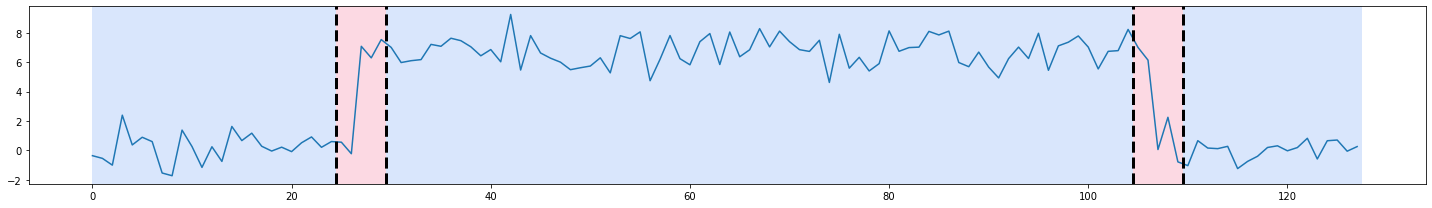

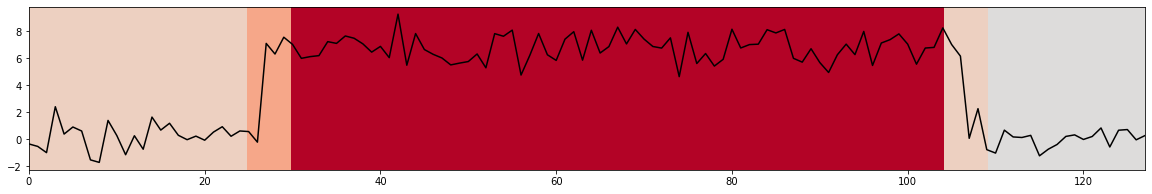

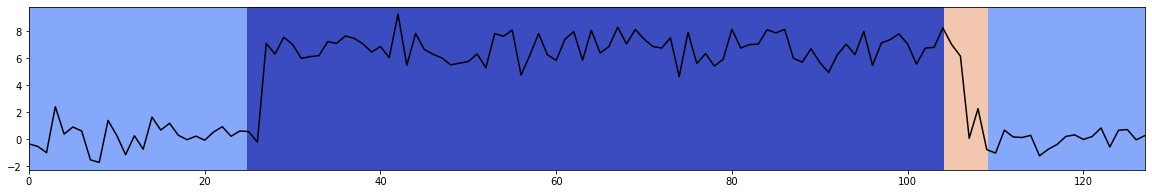

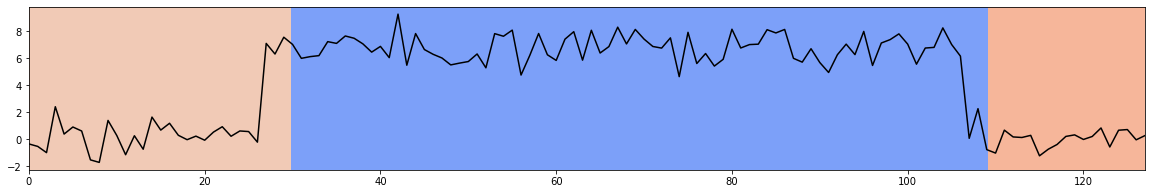

In [125]:
params = dict()
medoid_ts = X_exp_test[1]
print("blackbox predicted class:",blackbox_predict.predict(medoid_ts.flatten().reshape(1,-1,1)))
shap_values, segmentation = shap_ts(ts = medoid_ts, 
                                         classifier = blackbox, 
                                         input_dim = blackbox_input_dimensions, 
                                         figsize = figsize, 
                                         nsamples = params.get("nsamples", 1000),
                                         background = params.get("background", "linear_consecutive"),
                                         pen = params.get("pen", 1),
                                         model = params.get("peltmodel", "rbf"),
                                         jump = params.get("jump", 5)
                                   )

                                        
"""plot_shap(ts = medoid_ts, 
               shap_values = shap_values, 
               segmentation = segmentation, 
               figsize = figsize)"""
plot_aggregated_multi_shap_background(ts = medoid_ts, 
               shap_values = shap_values, 
               segmentation = segmentation, 
               figsize = figsize)

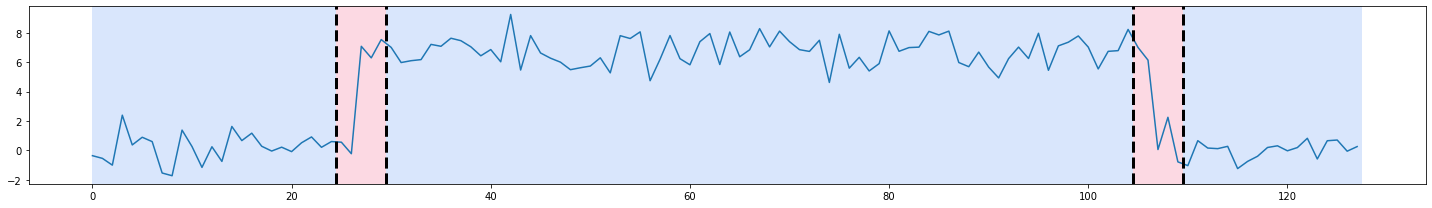

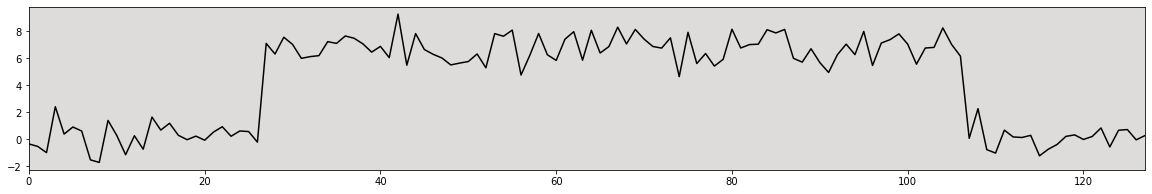

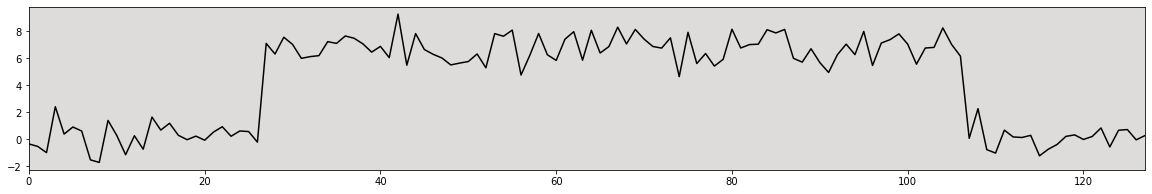

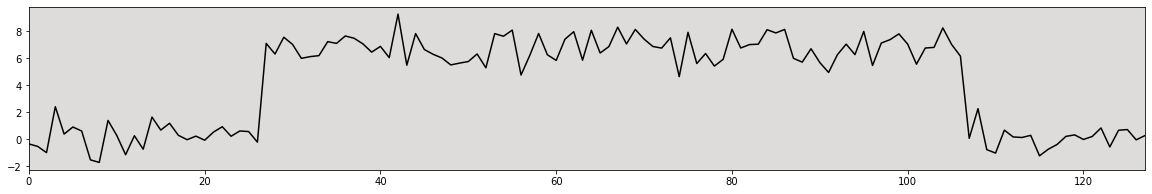

In [132]:
shap_values, segmentation = shap_ts(ts = medoid_ts, 
                                         classifier = blackbox, 
                                         input_dim = blackbox_input_dimensions, 
                                         figsize = figsize, 
                                         nsamples = params.get("nsamples", 1000),
                                         background = params.get("background", "linear"),
                                         pen = params.get("pen", 1),
                                         model = params.get("peltmodel", "rbf"),
                                         jump = params.get("jump", 5)
                                   )

                                        
"""plot_shap(ts = medoid_ts, 
               shap_values = shap_values, 
               segmentation = segmentation, 
               figsize = figsize)"""
plot_aggregated_multi_shap_background(ts = medoid_ts, 
               shap_values = shap_values, 
               segmentation = segmentation, 
               figsize = figsize)

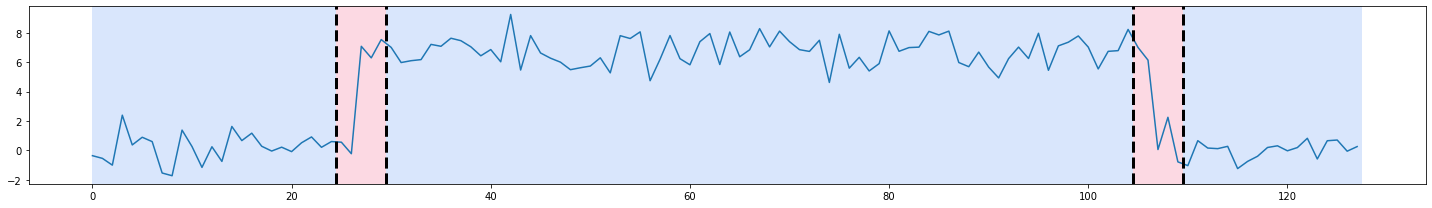

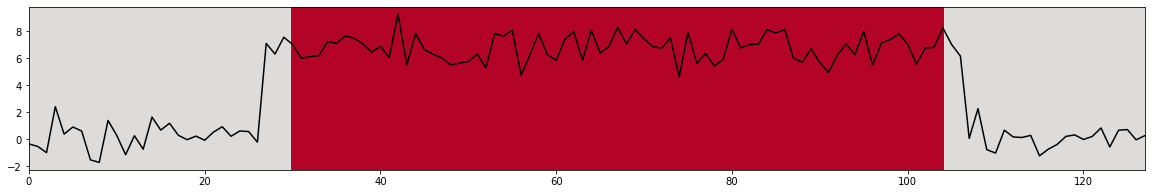

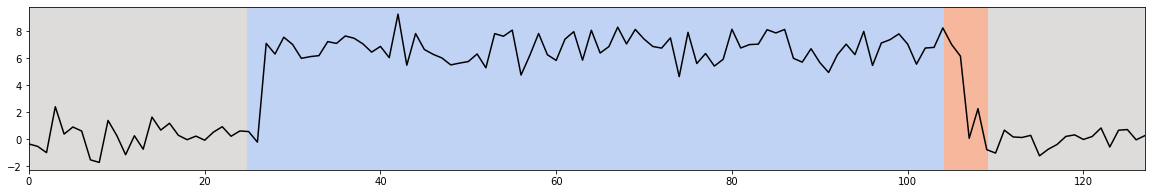

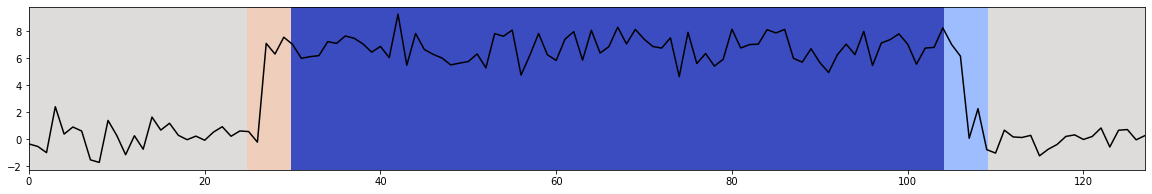

In [133]:
shap_values, segmentation = shap_ts(ts = medoid_ts, 
                                         classifier = blackbox, 
                                         input_dim = blackbox_input_dimensions, 
                                         figsize = figsize, 
                                         nsamples = params.get("nsamples", 1000),
                                         background = params.get("background", 0),
                                         pen = params.get("pen", 1),
                                         model = params.get("peltmodel", "rbf"),
                                         jump = params.get("jump", 5)
                                   )

                                        
"""plot_shap(ts = medoid_ts, 
               shap_values = shap_values, 
               segmentation = segmentation, 
               figsize = figsize)"""
plot_aggregated_multi_shap_background(ts = medoid_ts, 
               shap_values = shap_values, 
               segmentation = segmentation, 
               figsize = figsize)

### SHAP BY POINT

In [128]:
explainer = shap.KernelExplainer(knn.predict_proba, X_exp_test[:,:,0])

In [129]:
shap_values = explainer.shap_values(medoid_ts.ravel())

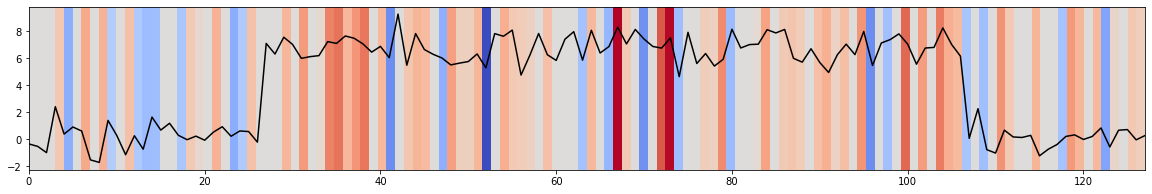

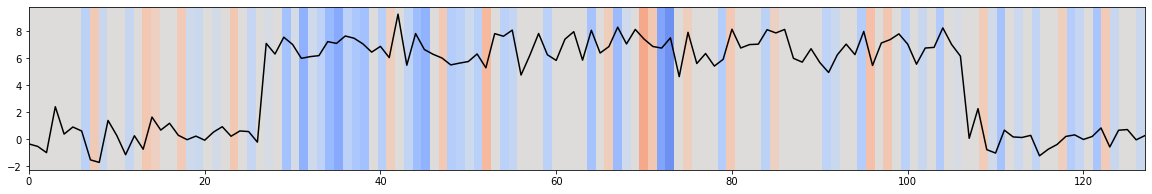

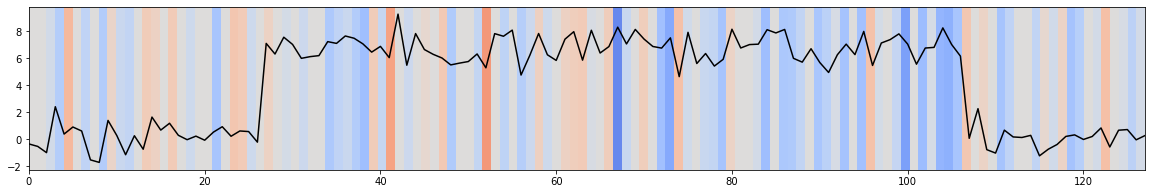

In [131]:
normalized_shap_values_array = []
flat_shap = np.ravel(np.array(shap_values))
minima = flat_shap.min()
maxima = flat_shap.max()

# these are here to avoid error in case there aren't values under or over 0 (for DiverginNorm)
if minima == 0: minima -= sys.float_info.epsilon
if maxima == 0: maxima += sys.float_info.epsilon

norm = matplotlib.colors.DivergingNorm(vmin=minima, vcenter=0, vmax=maxima)

for shap_array in shap_values:
    normalized_shap_array = norm(shap_array).flatten()
    normalized_shap_values_array.append(normalized_shap_array)

colors_by_point_array = np.array(normalized_shap_values_array)
#print(colors_by_point_array.shape)
aggregated_colors = colors_by_point_array#.mean(axis = 0)
#print(aggregated_colors.shape)
for i in range(aggregated_colors.shape[0]):
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(medoid_ts.reshape(1,-1).T, c = "black", alpha = 1)
    ax.pcolorfast((0, len(aggregated_colors[i,:])-1),
                  ax.get_ylim(),
                  aggregated_colors[i,:][np.newaxis],
                  cmap = "coolwarm", 
                  alpha=1, 
                  vmin = 0, 
                  vmax = 1
                  )
    fig.show()
    plt.show()